<a href="https://colab.research.google.com/github/RingoKid/EuroSAT-DeepLearning/blob/cnn/EuroSAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [28]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.image import resize
from google.colab import drive
import os
import json
import pickle

# Load the EuroSAT dataset (all bands version)
The EuroSAT dataset is loaded using `tfds.load()`. We use the `"eurosat/all"` version to get all spectral bands. The `with_info=True` flag provides metadata about the dataset (`info`), which gives us additional context like the number of classes, features, etc.


In [29]:
dataset, info = tfds.load("eurosat/all", split='train', with_info=True)


##### Mount Google Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Specify a directory in Google Drive to save the dataset
save_path = '/content/drive/My Drive/EuroSAT_datasets/'

# Save the dataset using TensorFlow's save method
tf.data.Dataset.save(dataset, os.path.join(save_path, 'eurosat_all'))
print("Dataset saved to Google Drive.")


In [ ]:
# Save dataset info using pickle
info_file_path = os.path.join(save_path, 'eurosat_info.pkl')
with open(info_file_path, 'wb') as f:
    pickle.dump(info, f)

In [ ]:
# Load the dataset from Google Drive
dataset = tf.data.Dataset.load(os.path.join(save_path, 'eurosat_all'))

# Load dataset info using pickle
info_file_path = os.path.join(save_path, 'eurosat_info.pkl')
with open(info_file_path, 'rb') as f:
    info = pickle.load(f)

print("Dataset and info loaded from Google Drive.")


Dataset and info loaded from Google Drive.


##### Data Description

In [3]:
# Get the dataset information
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/all/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    13 Sentinel-2 channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir=PosixGPath('/tmp/tmpsvl45kh2tfds'),
    file_format=tfrecord,
    download_size=1.93 GiB,
    dataset_size=5.36 GiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
        'sentinel2': Tensor(shape=(64, 64, 13), dtype=float32),
    }),
    supervised_keys=

In [30]:
info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    'sentinel2': Tensor(shape=(64, 64, 13), dtype=float32),
})

- **Name & Version**: The dataset name is `'eurosat/all/2.0.0'`, which means we are using version 2.0.0 of the dataset that contains all **13 Sentinel-2 spectral bands**.
- **Description**: The dataset is based on **Sentinel-2 satellite images** and consists of **13 spectral bands**, with 10 classes across **27,000 labeled samples**. The dataset offers two configurations—**'rgb'** (only R, G, B bands) and **'all'** (all 13 bands).
- **Data Size**: The **download size** of the dataset is **1.93 GiB**, and the total **dataset size** after processing is **5.36 GiB**.
- **Features**:
  - The dataset has three main features:
    - **'filename'**: This is a text feature that represents the filename.
    - **'label'**: This is an integer label with **10 classes**, which represent different types of land use or land cover.
    - **'sentinel2'**: This is a **tensor** of shape `(64, 64, 13)`, which means each image has dimensions **64x64** with **13 channels** (the spectral bands).
- **Supervised Keys**: The dataset is structured for supervised learning with input as `'sentinel2'` (the image) and output as `'label'`.
- **Splits**: The dataset is divided into a `'train'` split containing **27,000 examples**.

This information helps us understand what we are working with: a **multispectral dataset** with 13 bands per image, each of size **64x64** pixels, classified into **10 distinct classes**.



### Understanding the Dataset Structure
This snippet takes a look at a single sample from the dataset to understand its structure. This is useful for understanding how the data is stored, including keys such as `image`, `label`, and possibly others.


In [5]:
for sample in dataset.take(1):
    print("Sample Data:", sample)

Sample Data: {'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'River_15.tif'>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=8>, 'sentinel2': <tf.Tensor: shape=(64, 64, 13), dtype=float32, numpy=
array([[[1138.,  909.,  832., ...,  129.,   77.,  354.],
        [1138.,  909.,  832., ...,  129.,   77.,  354.],
        [1138.,  916.,  826., ...,  127.,   75.,  351.],
        ...,
        [1172.,  864.,  845., ..., 1939.,  952., 3965.],
        [1177.,  865.,  892., ..., 1943.,  987., 3889.],
        [1181.,  828.,  844., ..., 1927.,  986., 3874.]],

       [[1138.,  909.,  832., ...,  129.,   77.,  354.],
        [1138.,  909.,  832., ...,  129.,   77.,  354.],
        [1138.,  916.,  826., ...,  127.,   75.,  351.],
        ...,
        [1172.,  864.,  845., ..., 1939.,  952., 3965.],
        [1177.,  865.,  892., ..., 1943.,  987., 3889.],
        [1181.,  828.,  844., ..., 1927.,  986., 3874.]],

       [[1138.,  916.,  824., ...,  132.,   79.,  349.],
        [1138.,  916.,

## Display a few samples to get a sense of the data.




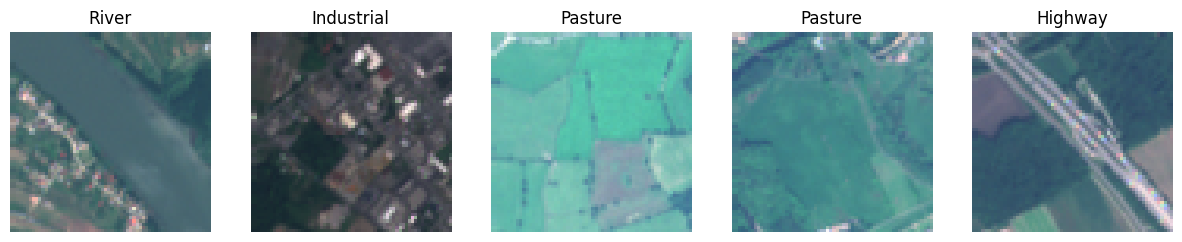

In [6]:
def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i, sample in enumerate(dataset.take(num_samples)):
        # Extract RGB channels: Band 4 (Red), Band 3 (Green), Band 2 (Blue)
        image = np.stack([
            sample['sentinel2'][:, :, 3],  # Red (Band 4)
            sample['sentinel2'][:, :, 2],  # Green (Band 3)
            sample['sentinel2'][:, :, 1]   # Blue (Band 2)
        ], axis=-1)

        label = sample['label']
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image / np.max(image))  # Normalize for better visualization
        plt.title(f"{info.features['label'].int2str(label)}")
        plt.axis('off')
    plt.show()

# Show 5 samples from the dataset
show_samples(dataset, num_samples=5)

This function (`show_samples`) is used to visualize a few samples from the dataset. It takes a specified number of samples (`num_samples`) and plots them using `matplotlib`. Each plot includes:
- The **image** itself, using only the **RGB channels** (Bands 4, 3, and 2) for easier visualization.
- The **label** converted from integer to string using `info.features['label'].int2str(label)`. Only the label is used in the title, without the filename.
- **Normalization** is applied when displaying the images to make sure the values are between 0 and 1, which enhances visualization.

This step helps to visually inspect the dataset and get a sense of the variety of classes and image quality.


# ResNet

### Resize images to the input size required by ResNet and GoogleNet (224x224)

In [31]:
# Resize images to the input size required by ResNet and GoogleNet (224x224)
def preprocess_image(image):
    # Extract RGB channels (Bands 4, 3, 2)
    image_rgb = tf.stack([
        image[:, :, 3],  # Red (Band 4)
        image[:, :, 2],  # Green (Band 3)
        image[:, :, 1]   # Blue (Band 2)
    ], axis=-1)

    # Resize to 224x224 for ResNet and GoogleNet
    image_resized = resize(image_rgb, (224, 224))

    # Normalize the image to [0, 1] range
    image_resized = image_resized / 255.0

    # Standardize with ImageNet mean and std
    imagenet_mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
    imagenet_std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
    image_normalized = (image_resized - imagenet_mean) / imagenet_std
    return image_normalized

In [32]:
# Apply preprocessing directly using TensorFlow Dataset API
def preprocess_dataset(dataset):
    def preprocess_function(sample):
        image = preprocess_image(sample['sentinel2'])
        label = sample['label']
        return image, label

    # Apply the preprocessing function to the entire dataset
    preprocessed_dataset = dataset.map(preprocess_function, num_parallel_calls=tf.data.AUTOTUNE)
    return preprocessed_dataset

### Preprocess the dataset

In [33]:
# Preprocess the dataset (using the entire dataset with efficient batching and prefetching)
preprocessed_dataset = preprocess_dataset(dataset)

### Split the Dataset

In [34]:
# Shuffle the dataset to ensure randomness
preprocessed_dataset = preprocessed_dataset.shuffle(buffer_size=10000, seed=42)

# Calculate dataset sizes
total_size = tf.data.experimental.cardinality(preprocessed_dataset).numpy()
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)

In [35]:
# Split the dataset
train_dataset = preprocessed_dataset.take(train_size)
remaining_dataset = preprocessed_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

In [36]:
# Apply batching after splitting
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [37]:
# Print the sizes of each split to verify
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {tf.data.experimental.cardinality(test_dataset).numpy()}")

Training set size: 18900
Validation set size: 4050
Test set size: 127


### Load Pre-trained ResNet50 Model and Modify for EuroSAT

In [38]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [39]:
# Load pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [40]:
# Freeze the pre-trained layers
base_model.trainable = False

In [42]:
# Create a new model
model = models.Sequential([
    base_model,  # Pre-trained ResNet50 as the feature extractor
    layers.GlobalAveragePooling2D(),  # Reduce dimensions to a single vector per feature map
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes for EuroSAT
])

# Summary of the model to verify
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23608202 (90.06 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [43]:
# Compile the Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [44]:
# Train the Model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10)


Epoch 1/10
591/591 [==============================] - 382s 638ms/step - loss: 0.4280 - accuracy: 0.8620 - val_loss: 0.2536 - val_accuracy: 0.9200
Epoch 2/10
591/591 [==============================] - 378s 638ms/step - loss: 0.2381 - accuracy: 0.9223 - val_loss: 0.2080 - val_accuracy: 0.9326
Epoch 3/10
591/591 [==============================] - 380s 638ms/step - loss: 0.1981 - accuracy: 0.9342 - val_loss: 0.1934 - val_accuracy: 0.9348
Epoch 4/10
591/591 [==============================] - 381s 640ms/step - loss: 0.1780 - accuracy: 0.9410 - val_loss: 0.1744 - val_accuracy: 0.9440
Epoch 5/10
591/591 [==============================] - 382s 641ms/step - loss: 0.1585 - accuracy: 0.9470 - val_loss: 0.1461 - val_accuracy: 0.9523
Epoch 6/10
591/591 [==============================] - 381s 640ms/step - loss: 0.1496 - accuracy: 0.9494 - val_loss: 0.1457 - val_accuracy: 0.9516
Epoch 7/10
591/591 [==============================] - 384s 647ms/step - loss: 0.1406 - accuracy: 0.9533 - val_loss: 0.1450 -

In [45]:
# Evaluate the Model on Test Set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

127/127 [==============================] - 70s 519ms/step - loss: 0.1172 - accuracy: 0.9627
Test Accuracy: 0.96
